<a href="https://colab.research.google.com/github/JamesPeralta/Machine-Learning-Algorithms/blob/master/TemperatureForecasting/TemperatureForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temperature-forecasting problem


### Imports

In [8]:
from google.colab import drive
import os
import numpy as np
from matplotlib import pyplot as plt


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Inspecting the data of the Jena weather dataset

In [9]:
data_dir = '/content/drive/My Drive/Datasets/JenaClimate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


### Parse the data

In [10]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

print(float_data.shape)

(420551, 14)


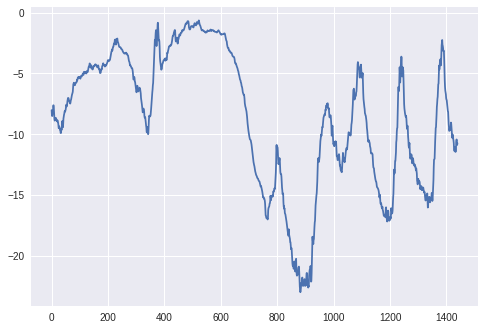

In [11]:
temp = float_data[:, 1]
plt.plot(range(1440), temp[:1440])

### Preparing the data
* Given data going as far back as *lookback* timesteps (a timestep is 10 minutes) and sampled every *steps* timesteps, can you predict the temperature in *delay* timesteps
 * lookback = 720—Observations will go back 5 days.
 * steps = 6—Observations will be sampled at one data point per hour.
 * delay = 144—Targets will be 24 hours in the future.

### To pre-process the data I will do two things
* Since each timerseries in the data is on a different scale, I will normalize each timerseries independently so that they all take small values on a similar scale
* Write a Python generator that takes the current array of float data and creates batches of data from the recent past, along with a target temp in the future.

#### Normalizing the data

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

#### Create a Data Generator
* Yields a tuple (samples, targets), where samples is one batch of input data and targets is the corresponding array of target temperatures
* Input: 
 * data—The original array of floating-point data, which you normalized above
 * lookback—How many timesteps back the input data should go.
 * delay—How many timesteps in the future the target should be.
 * min_index and max_index—Indices in the data array that delimit which time steps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
 * shuffle—Whether to shuffle the samples or draw them in chronological order.
 * batch_size—The number of samples per batch.
 * step—The period, in timesteps, at which you sample data. You’ll set it to 6 in
order to draw one data point every hour.
* Return:
 * Sample = [Sample1, Sample2, Sample3]
 * Results = [Result1, Result2, Result3]

In [0]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
        max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
        rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
        if i + batch_size >= max_index:
            i = min_index + lookback
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows)
    
    samples = np.zeros((len(rows), 
                        lookback // step, 
                        data.shape[-1]))
    
    targets = np.zeros((len(rows),))
    
    for j, row in enumerate(rows):
        indices = range(rows[j] - lookback, rows[j], step)
        samples[j] = data[indices]
        targets[j] = data[rows[j] + delay][1]
    yield samples, targets

### Prepare the training, validation, and test generators

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [0]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback)

In [16]:
print(val_steps)
print(test_steps)

769
119110


## Basic Dense Neural Network Baseline

In [0]:
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop

In [0]:
def createDenseModel():
  model = Sequential()
  model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1]))) 
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer=RMSprop(), loss='mae')
  
  return model

In [55]:
dense_model = createDenseModel()
history = dense_model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 16s 31ms/step - loss: 1.3944 - val_loss: 0.7206
Epoch 2/20
500/500 [==============================] - 15s 31ms/step - loss: 0.4593 - val_loss: 0.3656
Epoch 3/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2972 - val_loss: 0.3783
Epoch 4/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2703 - val_loss: 0.3192
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2559 - val_loss: 0.3117
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2483 - val_loss: 0.3163
Epoch 7/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2401 - val_loss: 0.3248
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2338 - val_loss: 0.3152
Epoch 9/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2298 - val_loss: 0.3253
Epoch 10/20
500/500 [==============================] - 15s 31ms/step - loss: 0.225

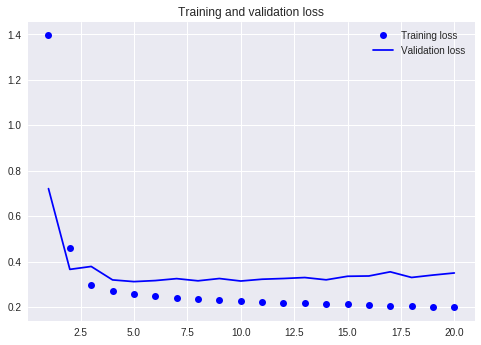

In [56]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## RNN Baseline

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [0]:
def createBaselineGRUModel():
  model = Sequential()
  model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
  model.add(layers.Dense(1))
  model.compile(optimizer=RMSprop(), loss='mae')
  
  return model

In [19]:
gru_model = createBaselineGRUModel()
history = gru_model.fit_generator(train_gen,
                                  steps_per_epoch=500,
                                  epochs=20,
                                  validation_data=val_gen,
                                  validation_steps=val_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 107s 213ms/step - loss: 0.3049 - val_loss: 0.2723
Epoch 2/20
500/500 [==============================] - 106s 212ms/step - loss: 0.2838 - val_loss: 0.2746
Epoch 3/20
500/500 [==============================] - 106s 212ms/step - loss: 0.2765 - val_loss: 0.2762
Epoch 4/20
500/500 [==============================] - 106s 212ms/step - loss: 0.2729 - val_loss: 0.2639
Epoch 5/20
500/500 [==============================] - 106s 212ms/step - loss: 0.2663 - val_loss: 0.2663
Epoch 6/20
500/500 [==============================] - 106s 212ms/step - loss: 0.2624 - val_loss: 0.2720
Epoch 7/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2581 - val_loss: 0.2665
Epoch 8/20
500/500 [==============================] - 106s 211ms/step - loss: 0.2531 - val_loss: 0.2663
Epoch 9/20
500/500 [============================

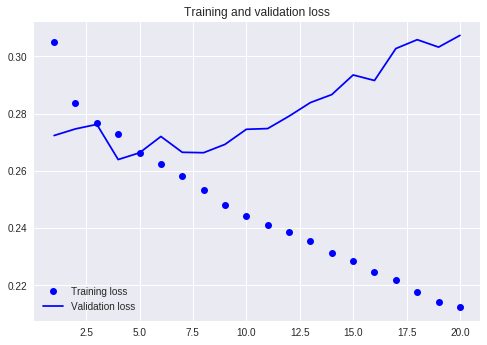

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Using recurrent dropout to fight overfitting
* The proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every time- step, instead of a dropout mask that varies randomly from timestep to timestep.
* Also, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask).

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 123s 246ms/step - loss: 0.3350 - val_loss: 0.2784
Epoch 2/40
500/500 [==============================] - 121s 242ms/step - loss: 0.3157 - val_loss: 0.2761
Epoch 3/40
500/500 [==============================] - 122s 243ms/step - loss: 0.3081 - val_loss: 0.2682
Epoch 4/40
500/500 [==============================] - 122s 245ms/step - loss: 0.3057 - val_loss: 0.2701
Epoch 5/40
500/500 [==============================] - 122s 245ms/step - loss: 0.3002 - val_loss: 0.2676
Epoch 6/40
500/500 [==============================] - 123s 246ms/step - loss: 0.2984 - val_loss: 0.2692
Epoch 7/40
500/500 [==============================] - 122s 245ms/step - loss: 0.2958 - val_loss: 0.2671
Epoch 8/40
500/500 [==============================] - 121s 243ms/step - loss: 0.2954 - val_loss: 0.2644
Epoch 9/40
500/500 [==============================] -

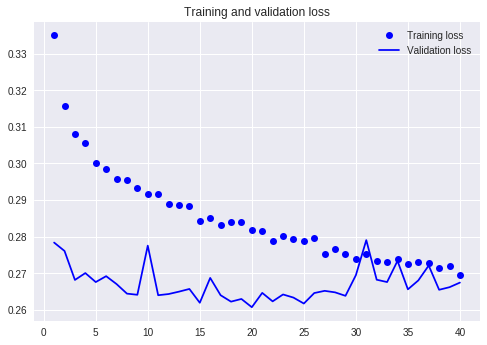

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Stacking recurrent layers (increase network capacity)
* It is generally a good idea to increase the capacity of your network until overfitting becomes the primary obstacle, As long as you aren’t overfitting too badly, you’re likely under capacity.
* What currently powers the Google Translate algorithm is a stack of seven large LSTM layers
* To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [0]:
model = Sequential()

model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Using bidirectional RNNs
* Frequently used in natural-language processing
* This method consists of using two regular RNNs, such as the GRU and LSTM layers, each of which processes the input sequence in one direc- tion (chronologically and antichronologically), and then merging their representations